In [66]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, confusion_matrix

from datetime import datetime
from dateutil.relativedelta import relativedelta

## 1. Import data

In [67]:
SO_detail = pd.read_csv("Data/Sales_SalesOrderDetail.csv", sep = ";")
SO_header = pd.read_csv("Data/Sales_SalesOrderHeader.csv", sep = ";")
SO_header_SalesReason = pd.read_csv("Data/Sales_SalesOrderHeaderSalesReason.csv", sep = ";")

Sales_customer = pd.read_csv("Data/Sales_Customer.csv", sep = ";")
Sales_territory = pd.read_csv("Data/Sales_SalesTerritory.csv", sep = ";")
Sales_reason = pd.read_csv("Data/Sales_SalesReason.csv", sep = ";")

Person_person = pd.read_csv("Data/Person_Person.csv", sep = ";")
Person_BusinessEntityContact = pd.read_csv("Data/Person_BusinessEntityContact.csv", sep = ";")

Purchasing_ShipMethod = pd.read_csv("Data/Purchasing_ShipMethod.csv", sep = ";")

Production_product = pd.read_csv("Data/Production_Product.csv", sep = ";")

In [68]:
# convert to date 
SO_header["OrderDate"] = pd.to_datetime(SO_header["OrderDate"], format = "%Y-%m-%d")
SO_header["DueDate"] = pd.to_datetime(SO_header["DueDate"], format = "%Y-%m-%d")
SO_header["ShipDate"] = pd.to_datetime(SO_header["ShipDate"], format = "%Y-%m-%d")
SO_header["ModifiedDate"] = pd.to_datetime(SO_header["ModifiedDate"], format = "%Y-%m-%d")

SO_detail["ModifiedDate"] = pd.to_datetime(SO_detail["ModifiedDate"], format = "%Y-%m-%d")

In [69]:
# Change Sales_territory a bit (will be handy later on)
Sales_territory["TerritoryName_ext"] = Sales_territory["CountryRegionCode"] + "_" + Sales_territory["Name"]

# Change Sales_reason a bit (will be handy later on)
Sales_reason = Sales_reason.rename(columns = {"Name" : "SalesReasonName"})

# Change Production_product a bit (will be handy later on)
Production_product = Production_product.rename(columns = {"Name" : "ProductName"})

In [70]:
# merge dataframes (will be useful later) 
SO = pd.merge(SO_header, SO_detail, how = 'left', on = 'SalesOrderID').merge(
    Sales_territory[["TerritoryID", "TerritoryName_ext"]], how = "left", on = "TerritoryID").merge( # Add territory information
    SO_header_SalesReason[["SalesOrderID", "SalesReasonID"]], how = "left", on = "SalesOrderID").merge( # Add the sales reason in two steps
    Sales_reason[["SalesReasonID", "SalesReasonName"]], how = "left", on = "SalesReasonID").merge(
    Production_product[["ProductID", "ProductName"]], how = "left", on = "ProductID")

## 2. Define time window 

For the time window, a lot depends upon the business itself as well. Since some products are sold very often and other products are not, let's take a very 'general' period of 1 year for which we want to predict whether a customer will churn or not. 

In other words, we want to predict for the next year (i.e. one year after the last reported order date in the data set) whether a customer will buy a product in this period or not. 

In order to do this, we first try to predict for the last year of our dataset since this allows us to check the performance of the model. 

Furthermore, we assume that the algorithm can be deployed in 1 day, resulting in a gap period of 1 day

In [71]:
# Sort SO_header 
SO_header = SO_header.sort_values(by = "OrderDate")

end_dependent = list(SO_header["OrderDate"])[-1] # the last date
start_dependent = end_dependent - relativedelta(years = 1) # one year earlier
end_independent = start_dependent - relativedelta(days = 1) # one day earlier

## 3. Data Preparation 

### 3.1 Select customers

In [72]:
SO_header_ind = SO_header[(SO_header["OrderDate"] <= end_independent)]# We only inspect customers who already bought products before the end of the independent period

### 3.2. Independent Variables

###### 3.2.1 Frequency 

In [73]:
frequency = SO_header_ind["CustomerID"].value_counts().reset_index()
frequency.columns = ["CustomerID", "frequency"] 

frequency.head()

,CustomerID,frequency
0,29580,9
1,29761,9
2,29994,9
3,29489,9
4,29811,9


,CustomerID,frequency
0,29580,9
1,29761,9
2,29994,9
3,29489,9
4,29811,9


In [74]:
frequency.shape

(6093, 2)

(6093, 2)

###### 3.2.2. Recency 

In [75]:
SO_header_ind["time_since_purchase"] = SO_header_ind["OrderDate"].apply(lambda x: end_independent - x)
recency = SO_header_ind.sort_values(['CustomerID','OrderDate'], ascending = [True, False]).drop_duplicates(['CustomerID'])
recency = recency[["CustomerID", "time_since_purchase"]]
recency = recency.rename(columns = {"time_since_purchase" : "recency"})

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
recency.head()

,CustomerID,recency
7863,11000,9 days
7834,11001,11 days
7579,11002,27 days
7656,11003,22 days
7936,11004,5 days


,CustomerID,recency
7863,11000,9 days
7834,11001,11 days
7579,11002,27 days
7656,11003,22 days
7936,11004,5 days


###### 3.2.3. Tenure 

In [77]:
tenure = SO_header_ind.sort_values(['CustomerID','OrderDate'], ascending = [True, True]).drop_duplicates(['CustomerID'])
tenure = tenure[["CustomerID", "time_since_purchase"]]
tenure = tenure.rename(columns = {"time_since_purchase" : "tenure"})

In [78]:
tenure.head()

,CustomerID,tenure
134,11000,739 days
108,11001,743 days
77,11002,751 days
42,11003,760 days
151,11004,735 days


,CustomerID,tenure
134,11000,739 days
108,11001,743 days
77,11002,751 days
42,11003,760 days
151,11004,735 days


###### 3.2.4. Monetary value

In [79]:
monetary_value = SO_header_ind.groupby("CustomerID")["SubTotal"].agg(["sum", "mean"]).reset_index()
monetary_value.columns = ["CustomerID", "monetary_value_tot", "monetary_value_avg"]

In [80]:
monetary_value.head()

,CustomerID,monetary_value_tot,monetary_value_avg
0,11000,5741.96,2870.980
1,11001,5794.92,2897.460
2,11002,5694.98,2847.490
3,11003,5718.95,2859.475
4,11004,5776.95,2888.475


,CustomerID,monetary_value_tot,monetary_value_avg
0,11000,5741.96,2870.980
1,11001,5794.92,2897.460
2,11002,5694.98,2847.490
3,11003,5718.95,2859.475
4,11004,5776.95,2888.475


###### 3.2.5. TerritoryID

In [81]:
# This method allows for customers buying products from a different region
# Eg, when people move houses
territories = pd.get_dummies(SO_header_ind[["CustomerID", "TerritoryID"]], columns = ["TerritoryID"]).groupby("CustomerID").agg("sum").reset_index()

In [82]:
territories.head()

,CustomerID,TerritoryID_1,TerritoryID_2,TerritoryID_3,TerritoryID_4,TerritoryID_5,TerritoryID_6,TerritoryID_7,TerritoryID_8,TerritoryID_9,TerritoryID_10
0,11000,0,0,0,0,0,0,0,0,2,0
1,11001,0,0,0,0,0,0,0,0,2,0
2,11002,0,0,0,0,0,0,0,0,2,0
3,11003,0,0,0,0,0,0,0,0,2,0
4,11004,0,0,0,0,0,0,0,0,2,0


,CustomerID,TerritoryID_1,TerritoryID_2,TerritoryID_3,TerritoryID_4,TerritoryID_5,TerritoryID_6,TerritoryID_7,TerritoryID_8,TerritoryID_9,TerritoryID_10
0,11000,0,0,0,0,0,0,0,0,2,0
1,11001,0,0,0,0,0,0,0,0,2,0
2,11002,0,0,0,0,0,0,0,0,2,0
3,11003,0,0,0,0,0,0,0,0,2,0
4,11004,0,0,0,0,0,0,0,0,2,0


In [83]:
# Set equal to 1 if used (>0) and 0 otherwise
territories.columns = ["CustomerID"] + list(Sales_territory["Name"]) # set the correct territories
columns = list(territories.columns)
columns.remove("CustomerID")
for column in columns: 
    territories[column] = np.where(territories[column]>0, 1, 0)

In [84]:
territories.head()

,CustomerID,Northwest,Northeast,Central,Southwest,Southeast,Canada,France,Germany,Australia,United Kingdom
0,11000,0,0,0,0,0,0,0,0,1,0
1,11001,0,0,0,0,0,0,0,0,1,0
2,11002,0,0,0,0,0,0,0,0,1,0
3,11003,0,0,0,0,0,0,0,0,1,0
4,11004,0,0,0,0,0,0,0,0,1,0


,CustomerID,Northwest,Northeast,Central,Southwest,Southeast,Canada,France,Germany,Australia,United Kingdom
0,11000,0,0,0,0,0,0,0,0,1,0
1,11001,0,0,0,0,0,0,0,0,1,0
2,11002,0,0,0,0,0,0,0,0,1,0
3,11003,0,0,0,0,0,0,0,0,1,0
4,11004,0,0,0,0,0,0,0,0,1,0


###### 3.2.6. Online order, Offline order or both? 

In [85]:
SO_header_ind["OfflineOrderFlag"] = SO_header_ind["OnlineOrderFlag"].apply(lambda x: False if x == True else True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
OnlineOffline = SO_header_ind[["OfflineOrderFlag", "OnlineOrderFlag", "CustomerID"]].groupby("CustomerID").agg("sum").reset_index()

In [87]:
columns = list(OnlineOffline.columns)
columns.remove("CustomerID")
for column in columns: 
    OnlineOffline[column] = np.where(OnlineOffline[column]>0, 1, 0)

In [88]:
OnlineOffline.head()

,CustomerID,OfflineOrderFlag,OnlineOrderFlag
0,11000,0,1
1,11001,0,1
2,11002,0,1
3,11003,0,1
4,11004,0,1


,CustomerID,OfflineOrderFlag,OnlineOrderFlag
0,11000,0,1
1,11001,0,1
2,11002,0,1
3,11003,0,1
4,11004,0,1


In [89]:
OnlineOffline["OnlineOrderFlag"].value_counts(dropna = False)

1    5630
0     463
Name: OnlineOrderFlag, dtype: int64

1    5630
0     463
Name: OnlineOrderFlag, dtype: int64

Note that this variable is not really balanced

In [90]:
# Check if there are customers buying online and offline
OnlineOffline[(OnlineOffline["OfflineOrderFlag"] == 1) & (OnlineOffline["OnlineOrderFlag"] == 1)]

,CustomerID,OfflineOrderFlag,OnlineOrderFlag


,CustomerID,OfflineOrderFlag,OnlineOrderFlag


Apparently, this does not occur.

###### 3.2.7. Credit Card payer

In [91]:
credit_card = SO_header_ind[["CustomerID", "CreditCardID"]].groupby("CustomerID").count().reset_index().rename(columns = {"CreditCardID": "CreditCard_indicator"})
credit_card["CreditCard_indicator"] = credit_card["CreditCard_indicator"].apply(lambda x: 1 if x > 0 else 0)
credit_card.head()

,CustomerID,CreditCard_indicator
0,11000,1
1,11001,1
2,11002,1
3,11003,1
4,11004,1


,CustomerID,CreditCard_indicator
0,11000,1
1,11001,1
2,11002,1
3,11003,1
4,11004,1


In [92]:
credit_card["CreditCard_indicator"].value_counts(dropna = False)

1    5850
0     243
Name: CreditCard_indicator, dtype: int64

1    5850
0     243
Name: CreditCard_indicator, dtype: int64

Note that this variable isn't really balanced

###### 3.2.8. Discount buyer

In [93]:
SO_ind = pd.merge(SO_header_ind, SO_detail, how = 'left', on = 'SalesOrderID')

In [94]:
discount_buyer = SO_ind[["CustomerID", "UnitPriceDiscount"]].groupby("CustomerID").mean().reset_index().rename(columns = {"UnitPriceDiscount" : "discount_indicator"})
discount_buyer["discount_indicator"] = discount_buyer["discount_indicator"].apply(lambda x: 1 if x > 0 else 0)
discount_buyer.head()

,CustomerID,discount_indicator
0,11000,0
1,11001,0
2,11002,0
3,11003,0
4,11004,0


,CustomerID,discount_indicator
0,11000,0
1,11001,0
2,11002,0
3,11003,0
4,11004,0


In [95]:
discount_buyer["discount_indicator"].value_counts()

0    5893
1     200
Name: discount_indicator, dtype: int64

0    5893
1     200
Name: discount_indicator, dtype: int64

###### 3.2.8. Average and max order quantity

In [96]:
order_quantity = SO_ind[["CustomerID", "OrderQty"]].groupby("CustomerID").agg({"OrderQty" : ["mean", "max"]}).reset_index()
order_quantity.columns = ["CustomerID", "meanOrderQty", "maxOrderQty"]
order_quantity = order_quantity.sort_values(by = "meanOrderQty")
order_quantity.tail(10)

,CustomerID,meanOrderQty,maxOrderQty
5780,29689,5.243094,15
5865,29795,5.300654,19
6045,30048,5.505618,20
6002,29987,5.545455,14
5731,29627,5.763359,21
5701,29589,6.260870,23
5980,29957,6.583710,28
5863,29793,7.069519,32
5784,29693,7.156863,36
5742,29641,8.050000,25


,CustomerID,meanOrderQty,maxOrderQty
5780,29689,5.243094,15
5865,29795,5.300654,19
6045,30048,5.505618,20
6002,29987,5.545455,14
5731,29627,5.763359,21
5701,29589,6.260870,23
5980,29957,6.583710,28
5863,29793,7.069519,32
5784,29693,7.156863,36
5742,29641,8.050000,25


In [97]:
order_quantity.shape

(6093, 3)

(6093, 3)

### 3.3. Dependent Variables

In [98]:
# customers in independent period
customers_ind = pd.DataFrame({
    "CustomerID" : np.unique(SO_header_ind["CustomerID"])
})

# customers in dependent period
SO_header_dep = SO_header[(SO_header["OrderDate"] > start_dependent) & (SO_header["OrderDate"] <= end_dependent)]
customers_dep = set(SO_header_dep["CustomerID"])

In [99]:
# Define churners as the customers whose ID's do not occur in the dependent period
customers_ind["churn"] = customers_ind["CustomerID"].apply(lambda x: 0 if x in customers_dep else 1)

In [100]:
churn = customers_ind

In [101]:
churn.head()

,CustomerID,churn
0,11000,0
1,11001,0
2,11002,0
3,11003,0
4,11004,0


,CustomerID,churn
0,11000,0
1,11001,0
2,11002,0
3,11003,0
4,11004,0


In [102]:
churn["churn"].value_counts(normalize = True)

0    0.832102
1    0.167898
Name: churn, dtype: float64

0    0.832102
1    0.167898
Name: churn, dtype: float64

There is roughly 17% churn

In [103]:
churn.shape

(6093, 2)

(6093, 2)

### 3.3. Basetable

In [104]:
basetable = frequency.merge(
    recency, how = "left", on = "CustomerID").merge(
    tenure, how = "left", on = "CustomerID").merge(
    monetary_value, how = "left", on = "CustomerID").merge(
    territories, how = "left", on = "CustomerID").merge(
    OnlineOffline, how = "left", on = "CustomerID").merge(
    credit_card, how = "left", on = "CustomerID").merge(
    discount_buyer, how = "left", on = "CustomerID").merge(
    order_quantity, how = "left", on = "CustomerID").merge(
    churn, how = "left", on = "CustomerID")

basetable = basetable.drop("CustomerID", axis = 1)
basetable.head()

,frequency,recency,tenure,monetary_value_tot,monetary_value_avg,Northwest,Northeast,Central,Southwest,Southeast,...,Germany,Australia,United Kingdom,OfflineOrderFlag,OnlineOrderFlag,CreditCard_indicator,discount_indicator,meanOrderQty,maxOrderQty,churn
0,9,30 days,760 days,540549.4208,60061.046756,1,0,0,0,0,...,0,0,0,1,0,1,1,4.714912,34,0
1,9,30 days,760 days,49849.8100,5538.867778,0,0,0,0,0,...,0,0,0,1,0,1,1,2.568421,18,0
2,9,30 days,760 days,565952.6242,62883.624911,0,0,0,0,0,...,0,0,0,1,0,1,1,4.032491,22,0
3,9,30 days,760 days,184445.3416,20493.926844,0,0,0,1,0,...,0,0,0,1,0,1,1,2.708609,11,0
4,9,30 days,760 days,140935.8238,15659.535978,0,0,0,0,1,...,0,0,0,1,0,1,1,3.091954,16,0


,frequency,recency,tenure,monetary_value_tot,monetary_value_avg,Northwest,Northeast,Central,Southwest,Southeast,...,Germany,Australia,United Kingdom,OfflineOrderFlag,OnlineOrderFlag,CreditCard_indicator,discount_indicator,meanOrderQty,maxOrderQty,churn
0,9,30 days,760 days,540549.4208,60061.046756,1,0,0,0,0,...,0,0,0,1,0,1,1,4.714912,34,0
1,9,30 days,760 days,49849.8100,5538.867778,0,0,0,0,0,...,0,0,0,1,0,1,1,2.568421,18,0
2,9,30 days,760 days,565952.6242,62883.624911,0,0,0,0,0,...,0,0,0,1,0,1,1,4.032491,22,0
3,9,30 days,760 days,184445.3416,20493.926844,0,0,0,1,0,...,0,0,0,1,0,1,1,2.708609,11,0
4,9,30 days,760 days,140935.8238,15659.535978,0,0,0,0,1,...,0,0,0,1,0,1,1,3.091954,16,0


In [105]:
basetable.shape

(6093, 22)

(6093, 22)

### 3.5. Missing Values

Check for missing values and handle as demanded in the assignment.

In [106]:
basetable.isnull().sum()

frequency               0
recency                 0
tenure                  0
monetary_value_tot      0
monetary_value_avg      0
Northwest               0
Northeast               0
Central                 0
Southwest               0
Southeast               0
Canada                  0
France                  0
Germany                 0
Australia               0
United Kingdom          0
OfflineOrderFlag        0
OnlineOrderFlag         0
CreditCard_indicator    0
discount_indicator      0
meanOrderQty            0
maxOrderQty             0
churn                   0
dtype: int64

frequency               0
recency                 0
tenure                  0
monetary_value_tot      0
monetary_value_avg      0
Northwest               0
Northeast               0
Central                 0
Southwest               0
Southeast               0
Canada                  0
France                  0
Germany                 0
Australia               0
United Kingdom          0
OfflineOrderFlag        0
OnlineOrderFlag         0
CreditCard_indicator    0
discount_indicator      0
meanOrderQty            0
maxOrderQty             0
churn                   0
dtype: int64

Feels good!

### 3.6. Scaling

In [107]:
# ten
basetable['tenure'] = basetable['tenure'].dt.days
basetable['recency'] = basetable['recency'].dt.days

scaler = StandardScaler() 

scaler.fit(basetable[["frequency", "recency", "tenure", "monetary_value_tot", "monetary_value_avg", "meanOrderQty", "maxOrderQty"]])

basetable[["frequency", "recency", "tenure", "monetary_value_tot", "monetary_value_avg", "meanOrderQty", "maxOrderQty"]] = scaler.transform(basetable[["frequency", "recency", "tenure", "monetary_value_tot", "monetary_value_avg", "meanOrderQty", "maxOrderQty"]])

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [108]:
basetable.head()

,frequency,recency,tenure,monetary_value_tot,monetary_value_avg,Northwest,Northeast,Central,Southwest,Southeast,...,Germany,Australia,United Kingdom,OfflineOrderFlag,OnlineOrderFlag,CreditCard_indicator,discount_indicator,meanOrderQty,maxOrderQty,churn
0,6.832758,-1.244764,1.898965,11.716078,6.890717,1,0,0,0,0,...,0,0,0,1,0,1,1,6.793695,10.783841,0
1,6.832758,-1.244764,1.898965,0.881111,0.231371,0,0,0,0,0,...,0,0,0,1,0,1,1,2.738382,5.458401,0
2,6.832758,-1.244764,1.898965,12.276997,7.235467,0,0,0,0,0,...,0,0,0,1,0,1,1,5.504413,6.789761,0
3,6.832758,-1.244764,1.898965,3.853068,2.057984,0,0,0,1,0,...,0,0,0,1,0,1,1,3.003236,3.128521,0
4,6.832758,-1.244764,1.898965,2.892350,1.467511,0,0,0,0,1,...,0,0,0,1,0,1,1,3.727480,4.792721,0


,frequency,recency,tenure,monetary_value_tot,monetary_value_avg,Northwest,Northeast,Central,Southwest,Southeast,...,Germany,Australia,United Kingdom,OfflineOrderFlag,OnlineOrderFlag,CreditCard_indicator,discount_indicator,meanOrderQty,maxOrderQty,churn
0,6.832758,-1.244764,1.898965,11.716078,6.890717,1,0,0,0,0,...,0,0,0,1,0,1,1,6.793695,10.783841,0
1,6.832758,-1.244764,1.898965,0.881111,0.231371,0,0,0,0,0,...,0,0,0,1,0,1,1,2.738382,5.458401,0
2,6.832758,-1.244764,1.898965,12.276997,7.235467,0,0,0,0,0,...,0,0,0,1,0,1,1,5.504413,6.789761,0
3,6.832758,-1.244764,1.898965,3.853068,2.057984,0,0,0,1,0,...,0,0,0,1,0,1,1,3.003236,3.128521,0
4,6.832758,-1.244764,1.898965,2.892350,1.467511,0,0,0,0,1,...,0,0,0,1,0,1,1,3.727480,4.792721,0


# 4. Modeling

## 4.1. Split basetable into training and test

In [109]:
X = basetable.drop("churn", axis = 1)
Y = basetable["churn"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=420)

In [110]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4265, 21)
(1828, 21)
(4265,)
(1828,)
(4265, 21)
(1828, 21)
(4265,)
(1828,)


In [111]:
X.shape

(6093, 21)

(6093, 21)

## 4.2. Logistic Regression

In [112]:
# initiate model
lr_model = LogisticRegression(max_iter = 10000, penalty = "l1")

# fit model
lr_model.fit(X_train, Y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [113]:
# get intercept
inter = pd.DataFrame({"Variable": "intercept", "Coefficient": lr_model.intercept_})
# get coefficients
coef = pd.DataFrame({"Variable": X_train.columns, "Coefficient": np.squeeze(lr_model.coef_)})
# join
inter_coef = pd.concat([inter, coef], axis=0)
# check
inter_coef

,Variable,Coefficient
0,intercept,-0.204062
0,frequency,-0.421655
1,recency,-1.350912
2,tenure,1.034319
3,monetary_value_tot,-0.196732
4,monetary_value_avg,0.293764
5,Northwest,0.045739
6,Northeast,-0.436088
7,Central,0.529679
8,Southwest,0.000000


,Variable,Coefficient
0,intercept,-0.204062
0,frequency,-0.421655
1,recency,-1.350912
2,tenure,1.034319
3,monetary_value_tot,-0.196732
4,monetary_value_avg,0.293764
5,Northwest,0.045739
6,Northeast,-0.436088
7,Central,0.529679
8,Southwest,0.000000


# 5. Evaluation

In [114]:
predictions = lr_model.predict(X_test) #This is what we would do if we would use a simple threshold of 0.5
pred_probabilities = lr_model.predict_proba(X_test) #We actually need the probabilities, we will target the 20% most probable to churn

In [115]:
# First column is probability of churn = 0, second probability of churn = 1
pred_probabilities

array([[0.6909007 , 0.3090993 ],
       [0.81009266, 0.18990734],
       [0.97001274, 0.02998726],
       ...,
       [0.77405998, 0.22594002],
       [0.83836568, 0.16163432],
       [0.56701655, 0.43298345]])

array([[0.6909007 , 0.3090993 ],
       [0.81009266, 0.18990734],
       [0.97001274, 0.02998726],
       ...,
       [0.77405998, 0.22594002],
       [0.83836568, 0.16163432],
       [0.56701655, 0.43298345]])

In [116]:
churn_prob = pred_probabilities[:,1]

In [117]:
evaluation_frame = pd.concat([pd.Series(churn_prob.reshape(len(Y_test))), Y_test.reset_index(drop=True)], axis = 1)
evaluation_frame.columns = ["probabilty", "actual_outcome"]

In [118]:
evaluation_frame.head()

,probabilty,actual_outcome
0,0.309099,0
1,0.189907,0
2,0.029987,0
3,0.086393,0
4,0.143142,0


,probabilty,actual_outcome
0,0.309099,0
1,0.189907,0
2,0.029987,0
3,0.086393,0
4,0.143142,0


In [119]:
# Now we'll order by probabilty
evaluation_frame = evaluation_frame.sort_values(by=['probabilty'], ascending = False)
evaluation_frame.head(10)

,probabilty,actual_outcome
566,0.909452,0
1154,0.892276,0
1785,0.883761,1
1192,0.877634,1
99,0.862938,1
449,0.856982,1
1326,0.836891,0
1708,0.829456,1
194,0.819515,0
1511,0.805792,0


,probabilty,actual_outcome
566,0.909452,0
1154,0.892276,0
1785,0.883761,1
1192,0.877634,1
99,0.862938,1
449,0.856982,1
1326,0.836891,0
1708,0.829456,1
194,0.819515,0
1511,0.805792,0


In [120]:
# We only want to have highest N (=0.20 of total) probabilties
highest_prob = evaluation_frame.nlargest(round((0.2*len(evaluation_frame))), ['probabilty'])['probabilty']

# We contact them all, thus we assume them all to be churners
evaluation_frame['expected_outcome'] = np.where(evaluation_frame['probabilty'].isin(highest_prob), 1, 0)

# Now compute the necessary values
accuracy = accuracy_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
precision = precision_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
recall = recall_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
tn, fp, fn, tp = confusion_matrix(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome']).ravel()

print("true positives :%s" %tp)
print("false positive: %s" %fp)
print("true negatives: %s" %tn)
print("false negatives: %s" %fn)
print("accuracy: %s" %accuracy)
print("recall: %s" %recall)
print("precision: %s" %precision)

true positives :142
false positive: 224
true negatives: 1296
false negatives: 166
accuracy: 0.7866520787746171
recall: 0.461038961038961
precision: 0.3879781420765027
true positives :142
false positive: 224
true negatives: 1296
false negatives: 166
accuracy: 0.7866520787746171
recall: 0.461038961038961
precision: 0.3879781420765027


In [121]:
def evaluation_function(threshold):
    highest_prob = evaluation_frame.nlargest(round((threshold*len(evaluation_frame))), ['probabilty'])['probabilty']

    #We contact them all, thus we assume them all to be churners
    evaluation_frame['expected_outcome'] = np.where(evaluation_frame['probabilty'].isin(highest_prob), 1, 0)

    #Now compute the necessary values
    accuracy = accuracy_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    precision = precision_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    recall = recall_score(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome'])
    tn, fp, fn, tp = confusion_matrix(evaluation_frame['actual_outcome'], evaluation_frame['expected_outcome']).ravel()

    print("true positives :%s" %tp)
    print("false positive: %s" %fp)
    print("true negatives: %s" %tn)
    print("false negatives: %s" %fn)
    print("accuracy: %s" %accuracy)
    print("recall: %s" %recall)
    print("precision: %s" %precision)

In [122]:
evaluation_function(0.15)

true positives :116
false positive: 158
true negatives: 1362
false negatives: 192
accuracy: 0.8085339168490153
recall: 0.37662337662337664
precision: 0.4233576642335766
true positives :116
false positive: 158
true negatives: 1362
false negatives: 192
accuracy: 0.8085339168490153
recall: 0.37662337662337664
precision: 0.4233576642335766


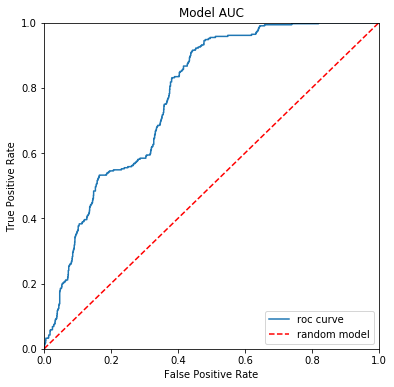

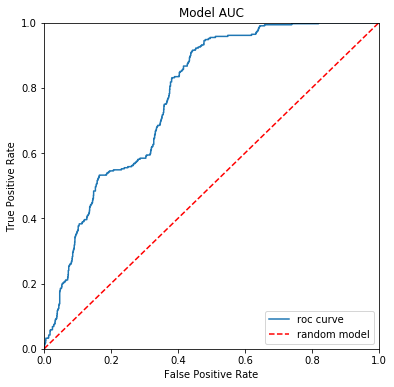

In [135]:
#Compute and plot ROC curve
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test, churn_prob)
plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate, label="roc curve") #plot our own curve
plt.plot([0, 1], [0, 1],'r--', label="random model") #plot what randomly saying 0 or 1 would do (=straight line)
plt.legend(loc = 'lower right') #plot legend
plt.xlim([0, 1]) 
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Model AUC")
plt.show()

In [124]:
#Compute AUC
roc_auc_score(Y_test, churn_prob)

0.7744841507177034

0.7744841507177034

## Lift

In [125]:
# join dependent variable and predictions of test set
label_pred = pd.DataFrame({"TARGET": Y_test,
                           "prediction": churn_prob})

# sort DataFrame by predicted probability
label_pred = label_pred.sort_values(by="prediction", ascending=False)

# check
label_pred.head(5)

,TARGET,prediction
301,0,0.909452
665,0,0.892276
359,1,0.883761
689,1,0.877634
490,1,0.862938


,TARGET,prediction
301,0,0.909452
665,0,0.892276
359,1,0.883761
689,1,0.877634
490,1,0.862938


In [126]:
# get global proportion of profitable customers in test set
prop_profitable_cust_test = label_pred["TARGET"].sum() / float(len(label_pred))
# check
print("proportion of profitable customers: %s" %prop_profitable_cust_test)

proportion of profitable customers: 0.16849015317286653
proportion of profitable customers: 0.16849015317286653


In [127]:
# calculate max lift
max_lift = 1. / prop_profitable_cust_test
# check
print("max lift: %s" %max_lift)

max lift: 5.9350649350649345
max lift: 5.9350649350649345


In [128]:
# initialize container for storing lift scores 
lift_scores = []
# loop through percentiles
for i in reversed(range(100)):
    # divide dataframes into percentiles of predicted probabilities
    start_perc = label_pred["prediction"].quantile(i / 100.)
    end_perc = label_pred["prediction"].quantile((i+1) / 100.)
    chunk = label_pred[(label_pred["prediction"] >= start_perc) &  (label_pred["prediction"] < end_perc)]
    # get size of chunk
    chunk_size = len(chunk)
    # get proportion of profitable customers in chunk
    prop_profitable_cust_chunk = chunk["TARGET"].sum() / float(chunk_size)
    # divide by global proportion of profitable customors
    lift = prop_profitable_cust_chunk / prop_profitable_cust_test
    # add to lift container
    lift_scores.append(lift)

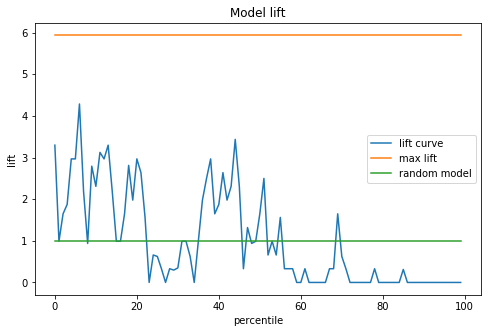

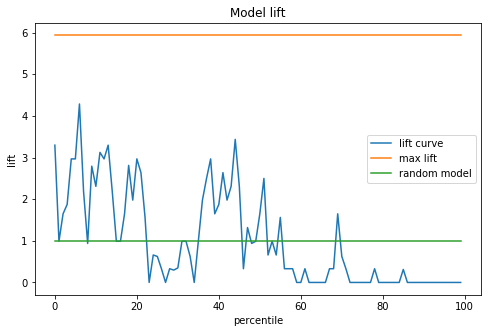

In [134]:
# plot lift curve
plt.figure(figsize=(8, 5))
plt.plot(range(100), lift_scores, label="lift curve")
plt.plot(range(100), [max_lift for i in range(100)], label="max lift")
plt.plot(range(100), [1 for i in range(100)], label="random model")
plt.xlabel("percentile")
plt.ylabel("lift")
plt.legend(loc="top right")
plt.title("Model lift")
plt.show()